In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from qbo1d.stochastic_forcing import sample_sf_cw
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist

import time

%load_ext autoreload
%autoreload 2

In [2]:
# data generator:
# parameter dicts
sfe = [3.7e-3, 3.8e-3, 3.2e-3, 3.8e-3, 3.8e-3]
sfv = [1e-8, 9e-8, 9e-8, 9e-10, 9e-8]
cwe = [32, 32, 40, 32, 32]
cwv = [225, 225, 225, 225, 225]
corr = [0.75, 0.75, 0.75, 0.75, -0.75]
seed = [int(21*9+8), int(21*9+7), int(21*6+15), int(21*12+5), int(21*2+10)]

# generate the matrix form

para_mat = np.array([sfe, sfv, cwe, cwv, corr, seed]).T

def data_generator(state=1):
    '''
    Input: state(0~4)
    STATE = 0 -> old control
    STATE = 1 -> new control
    STATE = 2 -> different mean
    STATE = 3 -> different variance
    STATE = 4 -> anti-correlation(non-physical) 

    Output: (u, s, sf, cw, solver)
    '''

    # Load the data manually
    # it takes 40 seconds

    t_max = 360 * 108 * 86400
    nsteps = 360 * 108
    nspinup = 360 * 12
    ntot = int(nsteps - nspinup)

    torch.set_default_dtype(torch.float64)

    # scenario 0 (control)
    # --------------------
    solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
    model = WaveSpectrum(solver, *para_mat[state])
    time = solver.time
    z = solver.z
    u = solver.solve(source_func=model)

    return u, model.s, model.sf, model.cw, solver



In [3]:
STATE = 0
u, s, sf, cw, solver = data_generator(state=STATE)

/Users/eddysmac/Desktop/QBO-1d/qbo1d/adsolver.py:145: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  u[n + 1] = torch.triangular_solve(b, self.R).solution.flatten()


In [4]:
# Data preprocessing
nsteps = 360 * 108
nspinup = 360 * 12


U = u[nspinup:nsteps, :]
SF = sf[nspinup:nsteps]
CW = cw[nspinup:nsteps]

U = torch.hstack([U[:, 1:-1], SF.view(-1, 1), CW.view(-1, 1)])

S = s[nspinup:nsteps, :]

# sc_U = StandardScaler()
sc_U = PCA(n_components=8, whiten=True)
sc_S = StandardScaler()

# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, S, test_size=0.8, random_state=42)




sc_U.fit(U_train[:, :-2])

def proc_U(X):
    return np.hstack([sc_U.transform(X[:, :-2]), X[:, -2:]])



U_train = proc_U(U_train)
U_test = proc_U(U_test)

s_train = sc_S.fit_transform(s_train)
s_test = sc_S.transform(s_test)

## Trial: 1d regression

In [5]:
s_train_35 = s_train[:, 35]
s_test_35 = s_test[:, 35]

In [6]:
svr = SVR(kernel='rbf', gamma='auto', epsilon=.5, C=32)
svr.fit(U_train, s_train_35)

SVR(C=32, epsilon=0.5, gamma='auto')

In [7]:
svr.n_support_

array([621], dtype=int32)

In [8]:
print(svr.score(U_test, s_test_35))
print(svr.score(U_train, s_train_35))

0.8497017262759938
0.8921187458039755


In [9]:
start = time.time()
print(svr.predict(U_test))
end = time.time()

print(end - start)

[-0.05094174  0.52712712  0.90455839 ...  0.31906981  0.36615877
  0.27645031]
1.955272912979126


## Multi-regression

In [55]:
svr_1d = SVR(kernel = 'rbf', gamma='auto', epsilon=.1, C=32)
mr = MultiOutputRegressor(svr)
mr.fit(U_train, s_train)

MultiOutputRegressor(estimator=SVR(C=32, epsilon=0.5, gamma='auto'))

In [56]:
mr.score(U_test, s_test)

0.8399420371076621

In [36]:
prediction = mr.predict(U_test)
prediction_ = sc_S.inverse_transform(prediction)
s_test_ = sc_S.inverse_transform(s_test)
mean_l2_loss_ = np.linalg.norm((prediction_ - s_test_), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss_}")


The loss of the linear regression: 1.9227016558699298e-05


# Try to do online testing

In [57]:
# use the last slice of the control run
initial_condition = lambda z: u[-1, :] 

In [58]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4, initial_condition=initial_condition)

# Set up the linear model to pass in the PDE

def model_ML_aug_1(x):
    x = torch.hstack([x[1:-1], sf[solver_ML.current_step], cw[solver_ML.current_step]])
    x = x.reshape(1, 73)
    x = proc_U(x)
    y = mr.predict(x)
    y = sc_S.inverse_transform(y)
    
    return torch.tensor(y[0])

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], sfe=3.7e-3, sfv=1e-8, cwe=32, cwv=225, corr=0.75, seed=int(21*9+8))

# def model_ML_aug_2(x):
#     x = torch.hstack([x[1:-1], sf_ML[solver_ML.current_step], cw_ML[solver_ML.current_step]])
#     x = x.reshape(1, 73)
#     return torch.tensor(reg.predict(x))[0]

model_ML_aug = lambda x:  1 * model_ML_aug_1(x) 

u_ML = solver_ML.solve(source_func=model_ML_aug)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [59]:
# Plotting function

def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    
    return ax_pos_absolute

def plot_76_tensors(u, solver, amp25=None, amp20=None, period=None, isu=True, text='model 0'):
    
    fig_size = (06.90, 02.20+01.50)
    fig = plt.figure(figsize=fig_size)

    ax = []

    ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

    cmin = -u.abs().max()
    cmax = u.abs().max()
    
    xmin = 84.
    xmax = 96.
    ymin = 17.
    ymax = 35.

    ax[0].set_xlim(left=84.)
    ax[0].set_xlim(right=96.)
    ax[0].set_ylim(bottom=17.)
    ax[0].set_ylim(top=35.)

    h = []

    h.append(ax[0].contourf(solver.time/86400/360, solver.z/1000, u.T,
                21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

    
    ax[0].set_ylabel('Km', fontsize=10)

    ax[0].set_xlabel('model year', fontsize=10)

    # Set ticks
    xticks_list = np.arange(xmin, xmax+1, 1)
    ax[0].set_xticks(xticks_list)

    yticks_list = np.arange(ymin, ymax+2, 2)
    ax[0].set_yticks(yticks_list)

    xticklabels_list = list(xticks_list)
    xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
    ax[0].set_xticklabels(xticklabels_list, fontsize=10)

    ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
    ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

    ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
    ax[0].tick_params(which='both', labelbottom=True)

    # if u, the display \tau and \sigma
    if isu:
        ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
        ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

        ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %period + 'months',
        horizontalalignment='left', verticalalignment='bottom', color='black')

    # The label it displays
    # u/s has different dimension
    if isu:
        label = r'$\mathrm{m s^{-1}}$'
    else:
        label = r'$\mathrm{m s^{-2}}$'
    
    # Color bars
    if isu:
        cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
        ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
        boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
        label=label)
    else:
        cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
        ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% .2e', 
        boundaries=np.linspace(cmin, cmax, 11), orientation='horizontal',
        label=label)
    
    plt.title(text)

    plt.legend()
    plt.show()

def rMSE(s_pred, s_gt, s_std):
    error = (s_gt - s_pred)
    SSE = sum(error ** 2)
    MSE = SSE/s_gt.shape[0]
    RMSE = MSE**.5
    return RMSE/s_std
    
def plot_rmse(*args):
    for i in range(len(args)):
        plt.plot(range(len(args[i])), args[i], label='model' + str(i))
    
    plt.xlabel('z level(indices)')
    plt.ylabel('rMSE')
    plt.title('Plot of rMSEs')
    plt.legend()
    plt.show()


def para_for_plotting(solver, u):
    # calculate amplitude and period
    spinup_time = 12*360*86400

    amp25 = utils.estimate_amplitude(solver.time, solver.z, u, height=25e3, spinup=spinup_time)
    amp20 = utils.estimate_amplitude(solver.time, solver.z, u, height=20e3, spinup=spinup_time)
    tau25 = utils.estimate_period(solver.time, solver.z, u, height=25e3, spinup=spinup_time)

    return {'amp25':amp25, 'amp20':amp20, 'period':tau25}

def plot_wind_level(u, level=35, text='MODEL 0'):
    plt.plot(u[:, level])
    plt.xlabel('timestep')
    plt.ylabel('zonal wind at z=' + str(level))
    plt.title(text)
    plt.show()


In [60]:
para_for_plotting(solver_ML, u_ML)

{'amp25': tensor(2.6640), 'amp20': tensor(2.2059), 'period': tensor(4.9456)}

No handles with labels found to put in legend.


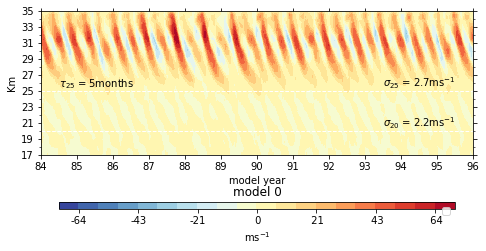

In [61]:
plot_76_tensors(u_ML, solver_ML, isu=True, **para_for_plotting(solver_ML, u_ML))

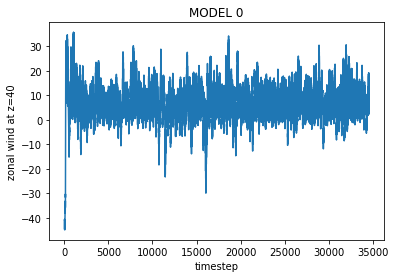

In [62]:
plot_wind_level(u_ML, level=40)